In [224]:
# Checkpoint to begin loading the Showdown data set

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as sp

gen5_types_df = pd.read_csv("./dataset/pokemon-fandom/pokemon_gen5_types_fixed.csv")
gen5_stats_df = pd.read_csv(r"dataset/bulbagarden/pokemon_gen5_stats.csv")
pokemon_counts_df = pd.read_csv("./dataset/showdown/showdown_2players.csv")
unique_pokemons_df = pd.read_csv("unique_pokemons.csv")
gen5ou_usage_latest = pd.read_csv("./dataset/smogon/2025-06-gen5ou-0.csv")

In [225]:
showdown_pokemon = pd.concat([pokemon_counts_df["Player " + str(m) + " Pokemon " + str(n)] for m in range(1, 3) for n in range(1, 7)], ignore_index=True)
showdown_pokemon.value_counts()
# Convert to DataFrame
df_counts = showdown_pokemon.value_counts().reset_index()

# Rename columns for clarity
df_counts.columns = ['Pokemon', 'Observed']
totalPolitoedReplay = df_counts[df_counts["Pokemon"] == "Politoed"]["Observed"].iloc[0]


In [226]:
pokemon_usage_expected = gen5ou_usage_latest.drop(["Usage%", "%", "Real", "%.1", "Rank"], axis=1)
pokemon_usage_expected

,Pokemon,Raw
0,Latios,24477
1,Tyranitar,23277
2,Ferrothorn,22418
3,Starmie,21626
4,Garchomp,20896
...,...,...
471,Ledian,1
472,Tirtouga,1
473,Minccino,1
474,Darumaka,1


In [227]:
totalPolitoed = pokemon_usage_expected[pokemon_usage_expected["Pokemon"] == "Politoed"]["Raw"].iloc[0]
totalPokemon = pokemon_usage_expected["Raw"].sum()
totalTeams = int(np.floor(pokemon_usage_expected["Raw"].sum() / 6))
print("Total Politoed uses in database: " + str(totalPolitoed))
print("Total Pokemon used: " + str(totalPokemon))
print("Total Pokemon teams: " + str(totalTeams))

Total Politoed uses in database: 11810
Total Pokemon used: 531591
Total Pokemon teams: 88598


In [228]:
# Prior Data from Smogon Database
alpha_prior = totalPolitoed
beta_prior = totalTeams - alpha_prior

print("Prior Belief: Beta(" + str(alpha_prior) + ", " + str(beta_prior) + ")")

alpha_posterior = alpha_prior + totalPolitoedReplay
beta_posterior = beta_prior + (10000 - totalPolitoedReplay)

print("Posterior Belief: Beta(" + str(alpha_posterior) + ", " + str(beta_posterior) + ")")


Prior Belief: Beta(11810, 76788)
Posterior Belief: Beta(14203, 84395)


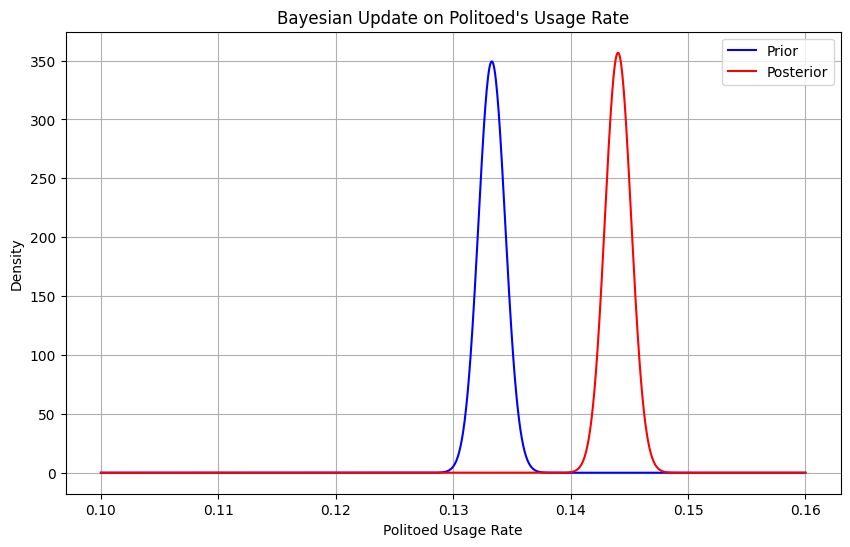

In [229]:
x_vals = np.linspace(0.1, 0.16, 1000)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_vals, sp.beta.pdf(x_vals, alpha_prior, beta_prior), label="Prior", color="blue")
plt.plot(x_vals, sp.beta.pdf(x_vals, alpha_posterior, beta_posterior), label="Posterior", color="red")
plt.title("Bayesian Update on Politoed's Usage Rate")
plt.xlabel("Politoed Usage Rate")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [230]:
# pokemonList = df_counts[pokemon_usage_expected["Raw"] > 100]["Pokemon"]

In [231]:
merged_df = df_counts.merge(pokemon_usage_expected[["Pokemon", "Raw"]], on="Pokemon")
pokemonList = merged_df[merged_df["Raw"] > 100]["Pokemon"].tolist()
totalPokemon = pokemon_usage_expected["Raw"].sum()
totalTeams = int(np.floor(totalPokemon / 6))
printing = False

print("Total Pokemon used: " + str(totalPokemon))
print("Total Pokemon teams: " + str(totalTeams))
print("\n")

results = []

for pokemon in pokemonList:
    totalPokemonReplay = df_counts[df_counts["Pokemon"] == pokemon]["Observed"].iloc[0]
    
    expected_data = pokemon_usage_expected[pokemon_usage_expected["Pokemon"] == pokemon]
    
    if expected_data.empty:
        print("Skipping " + pokemon + " — not found in expected data\n")
        continue

    totalPokemonUsageExpected = expected_data["Raw"].iloc[0]

    # Prior Data from Smogon Database
    alpha_prior = totalPokemonUsageExpected
    beta_prior = totalTeams - alpha_prior

    alpha_posterior = alpha_prior + totalPokemonReplay
    beta_posterior = beta_prior + (10000 - totalPokemonReplay)

    prior_mean = alpha_prior / (alpha_prior + beta_prior)
    prior_odds = prior_mean / (1 - prior_mean)

    posterior_mean = alpha_posterior / (alpha_posterior + beta_posterior)
    posterior_odds = posterior_mean / (1 - posterior_mean)

    bayes_factor = posterior_odds / prior_odds

    results.append({
        "Pokemon": pokemon,
        "Bayes Factor": bayes_factor
    })

    if pokemon == "Volcarona":
        print("Total " + pokemon + " uses in database: " + str(totalPokemonReplay))
        print("Prior Belief: Beta(" + str(alpha_prior) + ", " + str(beta_prior) + ")")
        print("Posterior Belief: Beta(" + str(alpha_posterior) + ", " + str(beta_posterior) + ")")
        print(pokemon + " Bayes Factor is: " + str(format(bayes_factor, ".4f")) + "\n\n")

df_bayes = pd.DataFrame(results)
df_bayes.sort_values(by="Bayes Factor", ascending=False)

Total Pokemon used: 531591
Total Pokemon teams: 88598


Total Volcarona uses in database: 879
Prior Belief: Beta(12135, 76463)
Posterior Belief: Beta(13014, 85584)
Volcarona Bayes Factor is: 0.9581




,Pokemon,Bayes Factor
70,Dugtrio,1.418031
76,Scyther,1.303563
91,Shedinja,1.212734
32,Tornadus,1.148683
50,Kyurem,1.135431
...,...,...
174,Galvantula,0.901742
197,Swellow,0.900792
196,Hitmonchan,0.900179
176,Serperior,0.900106


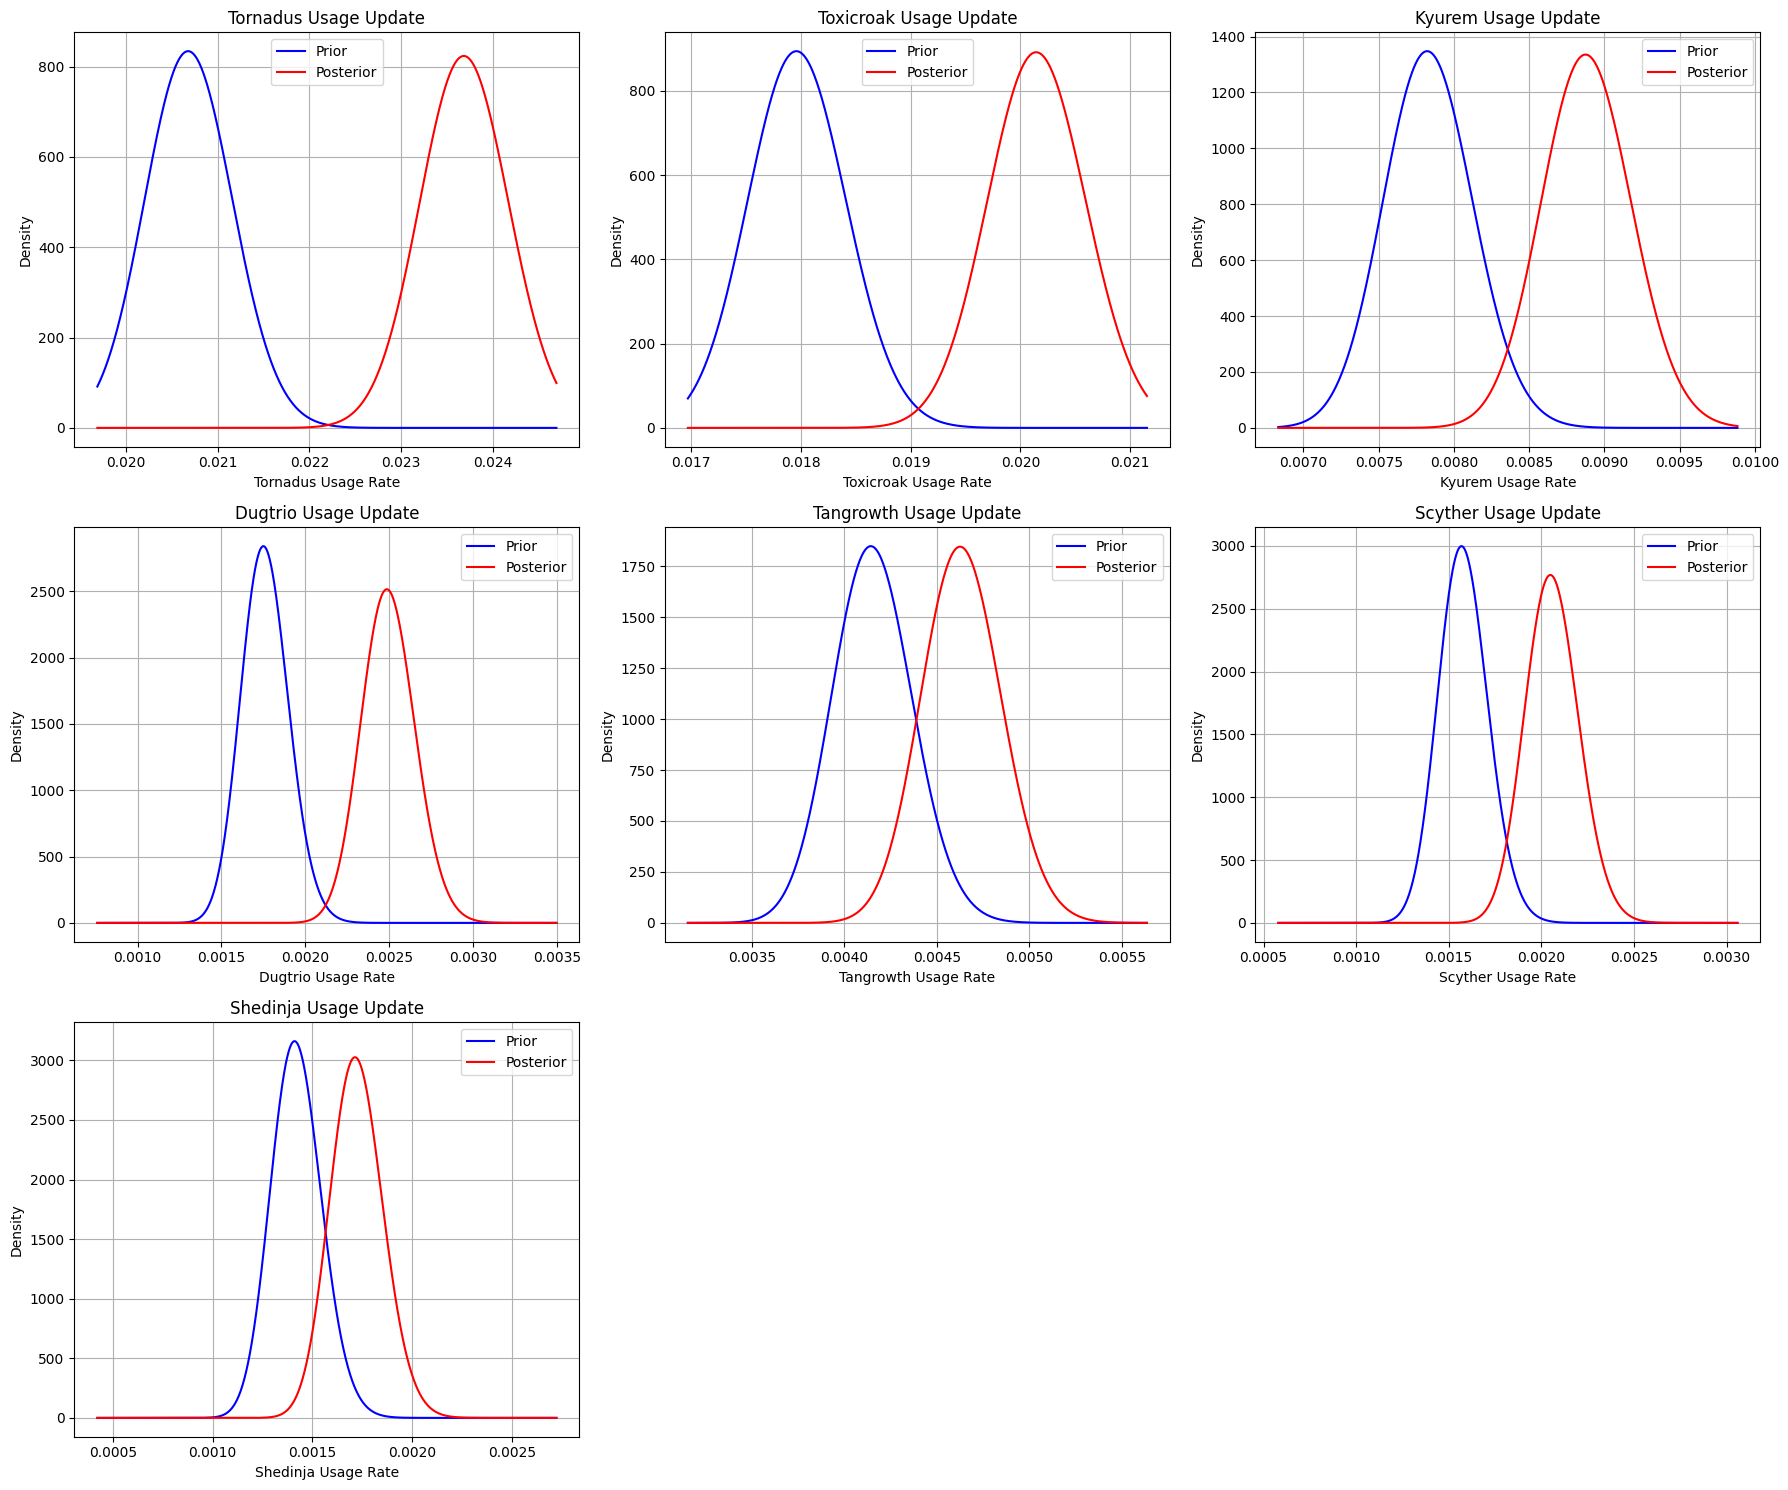

In [232]:
listOfInterest = df_bayes[df_bayes["Bayes Factor"] > 1.1]["Pokemon"].tolist()

# Set number of columns
cols = 3
rows = int(np.ceil(len(listOfInterest) / cols))

fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axs = axs.flatten()  # Flatten in case axs is 2D

for i, pokemon in enumerate(listOfInterest):
    totalPokemonReplay = df_counts[df_counts["Pokemon"] == pokemon]["Observed"].iloc[0]
    expected_data = pokemon_usage_expected[pokemon_usage_expected["Pokemon"] == pokemon]
    if expected_data.empty:
        continue

    totalPokemonUsageExpected = expected_data["Raw"].iloc[0]

    alpha_prior = totalPokemonUsageExpected
    beta_prior = totalTeams - alpha_prior

    alpha_posterior = alpha_prior + totalPokemonReplay
    beta_posterior = beta_prior + (10000 - totalPokemonReplay)

    prior_mean = alpha_prior / (alpha_prior + beta_prior)
    posterior_mean = alpha_posterior / (alpha_posterior + beta_posterior)

    x_vals = np.linspace(min(prior_mean, posterior_mean) - 0.001, max(prior_mean, posterior_mean) + 0.001, 1000)

    axs[i].plot(x_vals, sp.beta.pdf(x_vals, alpha_prior, beta_prior), label="Prior", color="blue")
    axs[i].plot(x_vals, sp.beta.pdf(x_vals, alpha_posterior, beta_posterior), label="Posterior", color="red")
    axs[i].set_title(f"{pokemon} Usage Update")
    axs[i].set_xlabel(f"{pokemon} Usage Rate")
    axs[i].set_ylabel("Density")
    axs[i].legend()
    axs[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
